In [1]:
import pandas as pd

#### Pre-Processing

In [66]:
df = pd.read_csv("../data/retail_transactions.csv")
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
265456,571918,23117,POPPY FIELDS CHOPPING BOARD,1,2011-10-19 16:05:00,4.95,17350.0,United Kingdom
264533,556876,20973,12 PENCIL SMALL TUBE WOODLAND,2,2011-06-15 11:56:00,0.65,16241.0,United Kingdom
67489,552185,84997D,CHILDRENS CUTLERY POLKADOT PINK,8,2011-05-06 13:52:00,4.15,12921.0,United Kingdom
59224,540798,21448,12 DAISY PEGS IN WOOD BOX,3,2011-01-11 12:11:00,1.65,17365.0,United Kingdom
315006,568921,22905,CALENDAR IN SEASON DESIGN,4,2011-09-29 14:40:00,2.95,17373.0,United Kingdom


In [67]:
# import pandas as pd

# df_spending = df[df["year"] == 2010]

# # Define custom aggregation function
# def custom_revenue(row):
#     total_spend = row['total_spend'].sum()
#     invoice_count = row['InvoiceNo'].nunique()
#     if total_spend * invoice_count > 10000:
#         return 10000
#     return total_spend * invoice_count

# # Assuming df_spending is your DataFrame filtered for year 2010
# df_spending_aggregate = df_spending.groupby(["CustomerID", "year"]).agg(
#     revenue2010=('total_spend', lambda x: custom_revenue(df_spending.loc[x.index])),
#     number_of_purchases=('InvoiceNo', 'nunique'),
# ).reset_index()

# # Display the aggregated DataFrame
# print(df_spending_aggregate)

In [68]:
df["year"] = pd.to_datetime(df["InvoiceDate"]).dt.year
df["total_spend"] = df.apply(lambda x: x["Quantity"] * x["UnitPrice"], axis=1)

df_spending = df[df["year"] == 2010]

# Group by CustomerID and year, and sum total_spend
df_spending_aggregate = df_spending.groupby(["CustomerID", "year"]).agg(
    revenue2010=('total_spend', lambda x : x.sum()),
    number_of_purchases=('InvoiceNo', lambda x : x.nunique()),
).reset_index()

df_spending_aggregate["avg_order_cost"] = df_spending_aggregate["revenue2010"] / df_spending_aggregate["number_of_purchases"]

df_revenue_2011 = df[df["year"] == 2011][["CustomerID", "total_spend"]]
df_revenue_2011.rename(columns={"total_spend": "revenue2011"}, inplace=True)
print(df_revenue_2011.sample(5));print("-"*50)

print(df_spending_aggregate.sample(5));print("-"*50)

# Display the aggregated DataFrame
print(df_spending_aggregate[df_spending_aggregate["CustomerID"] == 12347.0])

df_result = pd.merge(left=df_spending_aggregate, right=df_revenue_2011, how='left', on=['CustomerID'])
df_result.drop(columns=["year"], axis=1, inplace=True)
print(df_result.sample(5))

        CustomerID  revenue2011
302520     13458.0        10.08
146992     15815.0        40.00
168432     15053.0         4.00
281022     13081.0        33.00
255540     16341.0        20.40
--------------------------------------------------
     CustomerID  year  revenue2010  number_of_purchases  avg_order_cost
771     17659.0  2010       359.95                    2        179.9750
376     15093.0  2010       623.73                    1        623.7300
822     17905.0  2010       394.15                    2        197.0750
425     15454.0  2010       179.10                    1        179.1000
242     14180.0  2010       896.25                    4        224.0625
--------------------------------------------------
   CustomerID  year  revenue2010  number_of_purchases  avg_order_cost
0     12347.0  2010       711.79                    1          711.79
        CustomerID  revenue2010  number_of_purchases  avg_order_cost  \
46463      14527.0       925.49                    4      231.

In [69]:
df_result.sample(5)

,CustomerID,revenue2010,number_of_purchases,avg_order_cost,revenue2011
104712,16904.0,338.70,2,169.350,2.08
81586,15601.0,1236.45,2,618.225,19.92
96055,16456.0,787.40,1,787.400,1.25
14221,12921.0,687.80,2,343.900,15.00
102047,16746.0,311.64,1,311.640,20.80


#### Training

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [54]:
given_data = pd.read_csv("../data/wrangled_transactions.csv")
given_data.sample(5)

,CustomerID,2010 revenue,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,2011 revenue
305,15021.0,205.64,22.0,22.0,1.0,205.64,1709.18
163,13854.0,609.44,21.0,13.0,2.0,304.72,7500.08
364,15525.0,313.93,29.0,29.0,1.0,313.93,511.99
390,15680.0,478.89,22.0,22.0,1.0,478.89,854.79
104,13209.0,318.85,17.0,17.0,1.0,318.85,5572.76


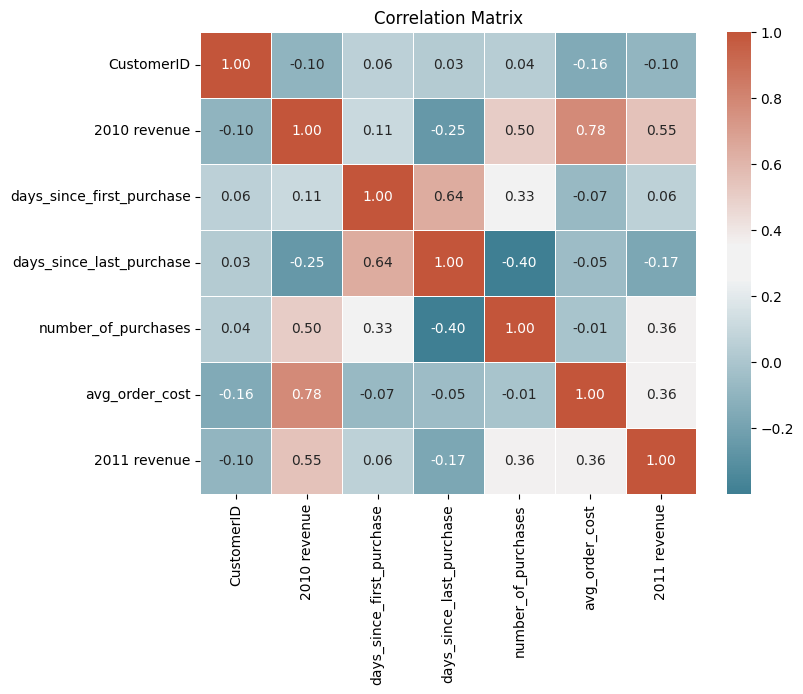

In [55]:
corr_matrix = given_data.corr()

# Create a diverging color palette
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

# Display the correlation matrix with color
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap=cmap, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [56]:
X = given_data[["2010 revenue", "days_since_last_purchase", "number_of_purchases", "avg_order_cost"]]
y = given_data[["2011 revenue"]]

In [57]:
print("X.shape:", X.shape);print("y.shape:", y.shape)

X.shape: (738, 4)
y.shape: (738, 1)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [59]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [60]:
#Train Score
print("R2: %.2f" %r2_score(y_train, model.predict(X_train)))
print("Mean squared error: %.2f" %mean_squared_error(y_train, model.predict(X_train)))

R2: 0.33
Mean squared error: 13505686.70


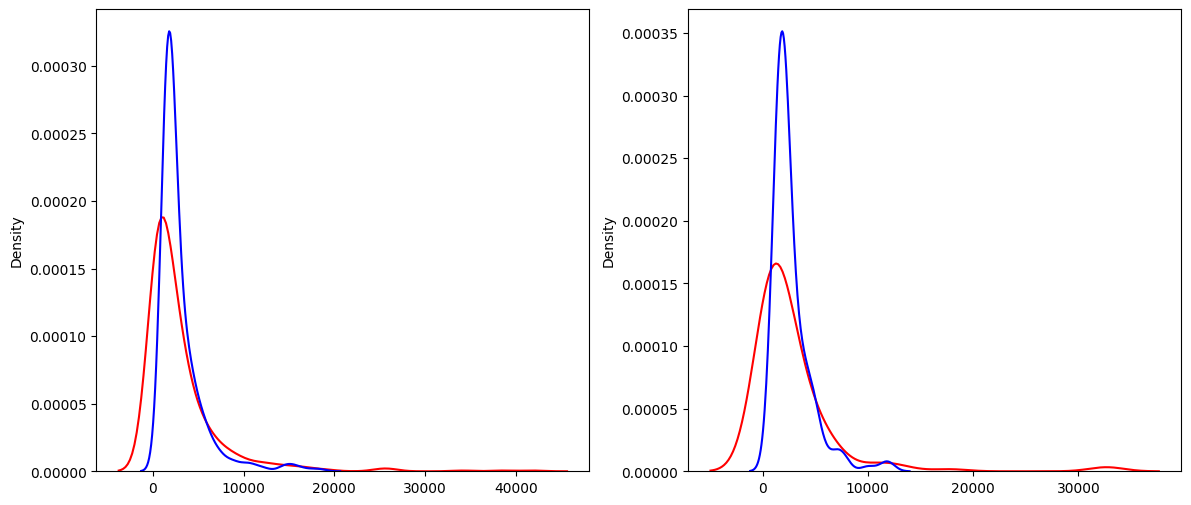

In [61]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
ax1 = sns.distplot(y_train, hist=False, color="r", 
                   label="Actual Train Values")
sns.distplot(model.predict(X_train), hist=False, color="b", 
             label="Predicted Train Values", ax=ax1)

plt.subplot(1,2,2)
ax2 = sns.distplot(y_test, hist=False, color="r", 
                   label="Actual Test Values")
sns.distplot(model.predict(X_test), hist=False, color="b", 
             label="Predicted Test Values" , ax=ax2)

plt.show()

In [65]:
X_now = np.array([1000, 20, 2, 500]).reshape(1, -1)
y_now = model.predict(X_now)

In [66]:
print(f"X_now= {X_now} => y_now = {y_now}")

X_now= [[1000   20    2  500]] => y_now = [[5782.20398341]]
